In [23]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
print("IMPORT: Success")

IMPORT: Success


In [24]:
df = pd.read_csv('dataset.csv')

In [25]:
print(f"Размеры датасета: {df.shape}\n")
print("\n--- Общая информация ---")
df.info()

Размеры датасета: (114000, 21)


--- Общая информация ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrument

In [26]:
print("Типы данных: ")
print(df.dtypes)

Типы данных: 
Unnamed: 0            int64
track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object


In [27]:
print("\nПропуски: ")
print(df.isnull().sum())
print(f"\nВсего пропусков: {sum(df.isnull().sum())}")


Пропуски: 
Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

Всего пропусков: 3


| Имя столбца        | Описание                                                                        | Тип данных |
| ------------------ | ------------------------------------------------------------------------------- | ---------- |
| `track_id`         | Уникальный идентификатор трека в Spotify                                        | `string`   |
| `artists`          | Имя или список исполнителей трека                                               | `string`   |
| `album_name`       | Название альбома, в который входит трек                                         | `string`   |
| `track_name`       | Название трека                                                                  | `string`   |
| `popularity`       | Уровень популярности трека                                         | `int`      |
| `duration_ms`      | Продолжительность трека в миллисекундах                                         | `int`      |
| `explicit`         | Присутствует ли в треке нецензурная лексика (`True` / `False`)                  | `bool`     |
| `danceability`     | Танцевальность трека (0-1)                 | `float`    |
| `energy`           | Энергичность трека (0–1)                   | `float`    |
| `key`              | Тональность трека, закодированная числом от 0 до 11    | `int`      |
| `loudness`         | Средняя громкость трека                     | `float`    |
| `mode`             | Лад трека (0 или 1)                                             | `int`      |
| `speechiness`      | Доля речевых элементов в треке (0–1)                                            | `float`    |
| `acousticness`     | Вероятность того, что трек является акустическим (0–1)                          | `float`    |
| `instrumentalness` | Вероятность того, что трэк является инструментальным (0–1) | `float`    |
| `liveness`         | Вероятность того, что запись сделана "вживую" (0–1)                             | `float`    |
| `valence`          | Эмоциональная окраска трека: от грустного (0) до радостного (1)                 | `float`    |
| `tempo`            | Темп трека в ударах в минуту (BPM)                                              | `float`    |
| `time_signature`   | Размер трека (например, 4 означает 4/4)                                         | `int`      |
| `track_genre`      | Музыкальный жанр трека                                                          | `string`   |


## Удаление пропусков
Всего пропусков - 3 <br>
Всего данных в датасете - 114000 * 21 = 2 394 000 вхождений <br>
Доля данных с пропусками - 0.0000008 <br>
Доля данных с пропусками крайне мала, -> даннные с пропусками можно просто удалить

In [28]:
df = df.dropna() # удаляем все строки с пропусками
print(sum(df.isnull().sum()))
print(df.shape) # удалена была одна строчка

0
(113999, 21)


Так же стоит удалить безымянный столбец, ибо он нафиг не нужон, безымянный ваш!

In [29]:
del df['Unnamed: 0']

## Предобработка для EDA
Удаляем дубликаты, меняем данные с типом bool на тип int

In [30]:
# Преобразуем explicit из bool/строки в 0 и 1
if df['explicit'].dtype == 'bool':
    df['explicit'] = df['explicit'].astype(int)
else:
    df['explicit'] = df['explicit'].apply(lambda x: 1 if str(x).lower() == 'true' else 0)

# Проверка дубликатов
duplicates = df.duplicated(subset=['track_id']).sum()
print(f"\nКоличество дубликатов по track_id: {duplicates}")


# Удалим дубликаты, если они есть
df = df.drop_duplicates(subset=['track_id'], keep='first')



Количество дубликатов по track_id: 24259


## EDA

## Проверка корреляции столбцов между собой


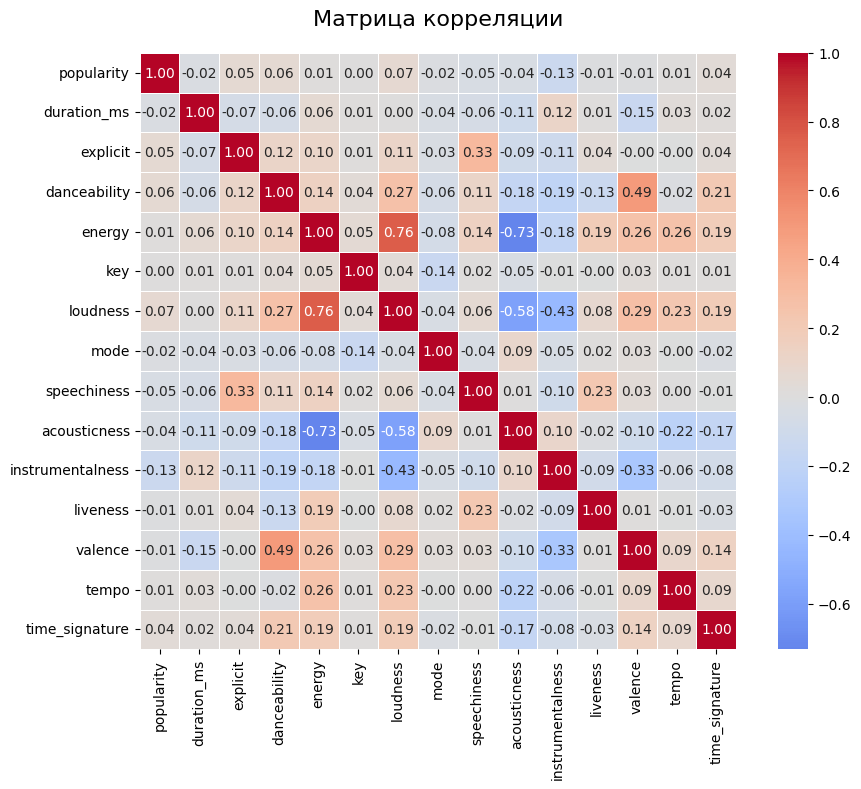

In [31]:
corr_matrix = df.corr(numeric_only=True)

# Создаем тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True,        # Показывать значения в ячейках
            fmt='.2f',         # Формат чисел (2 знака после запятой)
            cmap='coolwarm',   # Цветовая схема
            center=0,          # Центр цветовой шкалы
            square=True,       # Квадратные ячейки
            linewidths=0.5)    # Ширина линий между ячейками

plt.title('Матрица корреляции', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

### Обзор матрицы корреляции:
 - Танцевальность сильно коррелирует с эмоциаональной окраской (valence) - k = 0.49
 - Acousticness очень сильно коррелирует с энергичностью - k=-0.73
 - Инструментальность сильно коррелирует с громкостью - k=-0.43
 - Громкость очень сильно коррелирует с энергичностью - k=0.76
 - Громкость очень сильно коррелирует с аакустичностью - k=-0.58
 - Популярность (таргет) ни с чем явно не коррерирует - k в пределах(-0.05, 0.13)
 - Длительность и тональность так же ни с чем явно не коррерируют
 
### Выводы из матрицы корреляции:
 - Тагрет ни с чем не коррелирует -> в учебных данных не зашит ответ, вероятна мультиколлинеарность

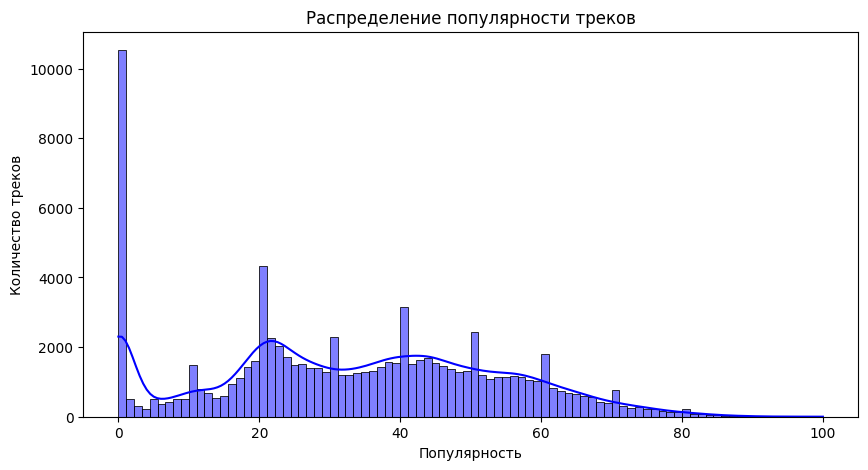

In [32]:

# --- Распределение популярности треков ---
plt.figure(figsize=(10,5))
sns.histplot(df['popularity'], bins=90, kde=True, color='blue')
plt.title('Распределение популярности треков')
plt.xlabel('Популярность')
plt.ylabel('Количество треков')
plt.show()

### Выводы:
Гистограмма показывает, как распределены треки по популярности.

Ярко выражен пик в нулевой популярности <br>
Примечательно: видны пики с популярностью, кратной 10 (10, 20, 30 и тд)<br>
Количество трэков с популярностью выше 60 быстро убывает<br>
Трэки с популярностью выше 80 почти отсутствуют <br>

In [33]:
# df = df[df['popularity'] > 0]


## Посмотрим на зависимости между таргетом и другими столбцами

### Гипотеза: Трэки с матом более популярны

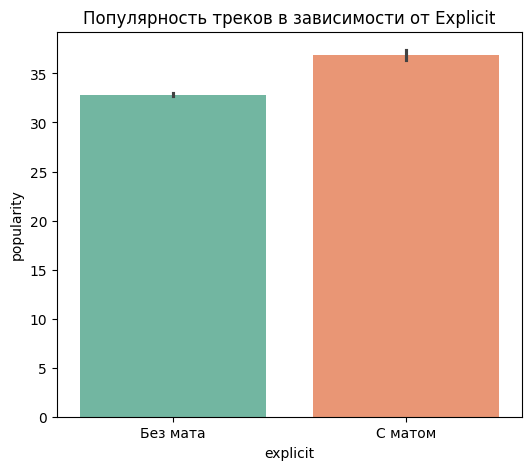

In [34]:
# --- Популярность в зависимости от Explicit-контента ---
plt.figure(figsize=(6,5))
sns.barplot(data=df, x='explicit', y='popularity', palette='Set2', legend=False, hue="explicit")
plt.title('Популярность треков в зависимости от Explicit')
plt.xticks([0,1], ['Без мата', 'С матом'])
plt.show()


### Вывод
Песни с матом чуть популярнее, чем песни без мата. 

### Гипотеза: Популярность связана с аккустичностью и интструментальностью

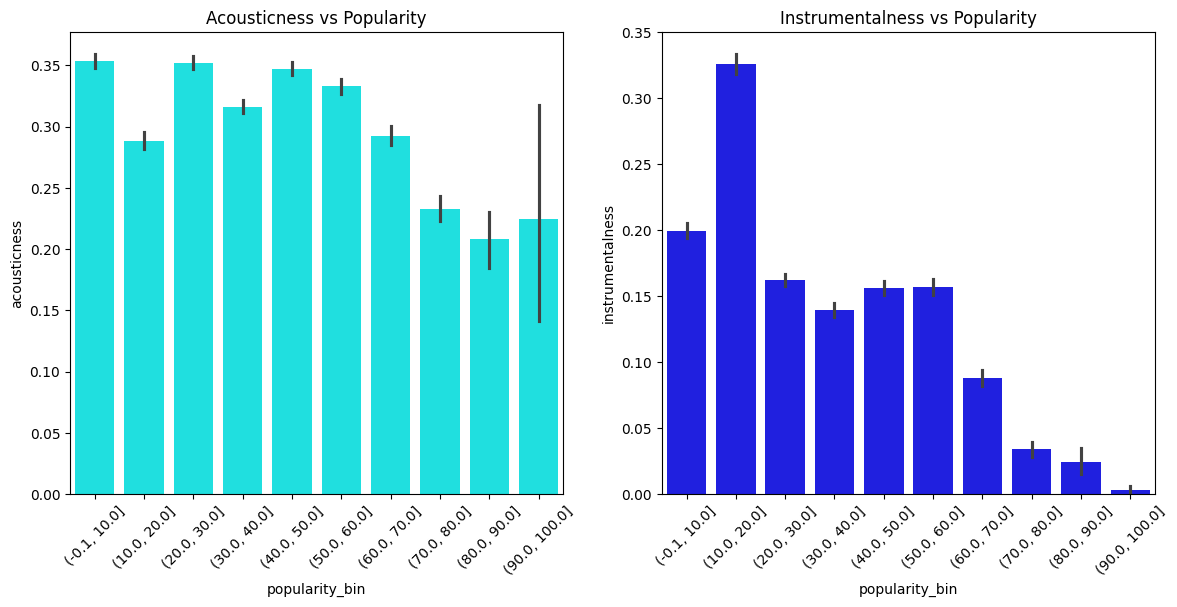

In [35]:

fig, ax = plt.subplots(1,2, figsize=(14,6))
df['popularity_bin'] = pd.cut(df['popularity'], bins=10)

sns.barplot(x='popularity_bin', y='acousticness', data=df, color='cyan', ax=ax[0])
ax[0].set_title('Acousticness vs Popularity')
ax[0].tick_params(axis='x', rotation=45)

sns.barplot(x='popularity_bin', y='instrumentalness', data=df, color='blue', ax=ax[1])
ax[1].set_title('Instrumentalness vs Popularity')
ax[1].tick_params(axis='x', rotation=45)
plt.show()

del df['popularity_bin']

### Выводы
 - В среднем более аккустичные трэки более популярны, чем инструментальные
 - С ростом популярность средняя инструментальность трэков резко убывает, тогда как аккустичность падает куда слабее 

### Гипотеза: слишком короткие и слишком длинные треки менее популярны, а оптимальная длительность для популярности — около 3–4 минут.

<Axes: xlabel='duration_min', ylabel='mean_popularity'>

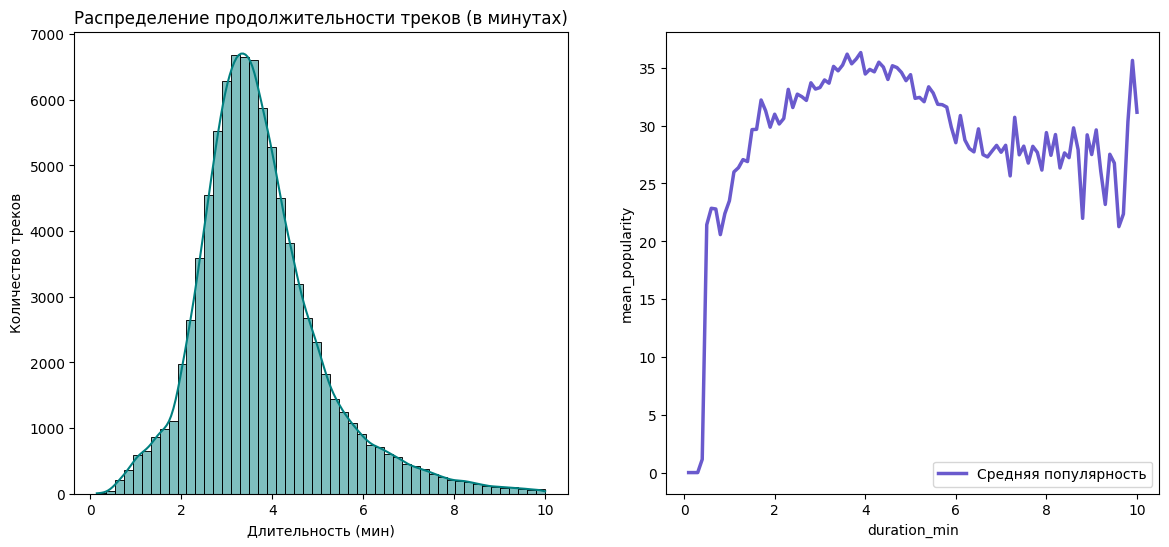

In [36]:

# --- Подготовка данных ---
df['duration_min'] = df['duration_ms'] / 60000
df_filtered = df[df['duration_min'] < 10]

df_grouped = (
    df_filtered
    .groupby(df_filtered['duration_min'].round(1))
    .agg(mean_popularity=('popularity', 'mean'))
    .reset_index()
)

# --- Фигура с двумя графиками рядом ---
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# --- График 1: распределение длительности ---
sns.histplot(df_filtered['duration_min'], bins=50, kde=True, color='teal', ax=ax[0])
ax[0].set_title('Распределение продолжительности треков (в минутах)')
ax[0].set_xlabel('Длительность (мин)')
ax[0].set_ylabel('Количество треков')

# --- График 2: зависимость популярности от длительности ---
sns.lineplot(
    data=df_grouped,
    x='duration_min',
    y='mean_popularity',
    color='slateblue',
    linewidth=2.5,
    label='Средняя популярность',
    ax=ax[1]
)


### Выводы
* В среднем продолжительность трэков находится в районе 3.8 - 4 минуты, что ожидаемо
* Популярность растёт с увеличением длительности до ~3–4 минут, после чего начинает стабилизироваться или немного снижаться.
* После 5 минут тренд становится шумным, что логично — таких треков мало, и усреднение менее устойчиво.

В целом, гипотезу можно считать подтвердившейся

### Гипотеза: Некоторые исполнители стабильно выпускают более популярные треки.

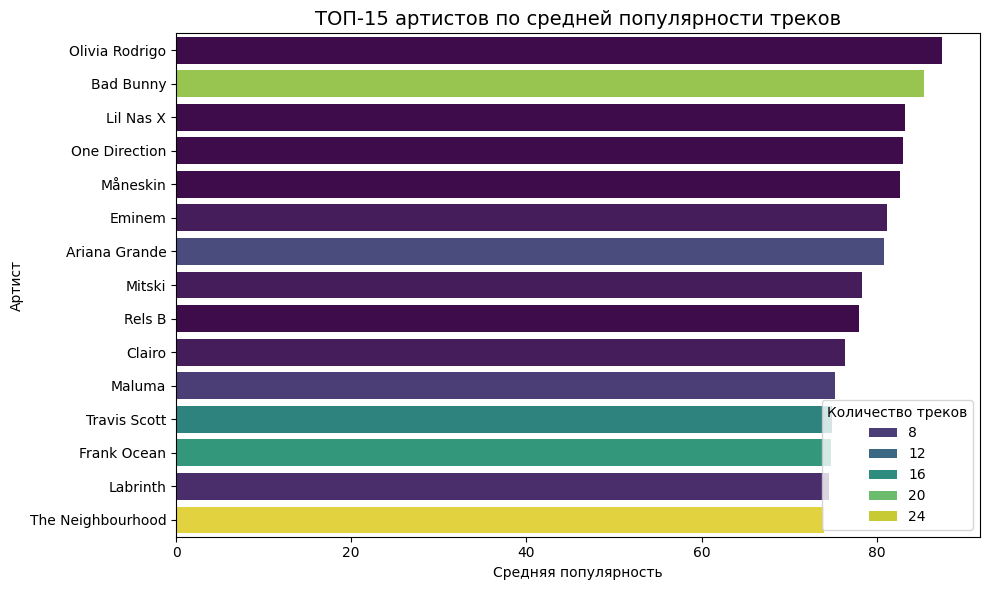

C:\Users\User\AppData\Local\Temp\ipykernel_12652\1068415004.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


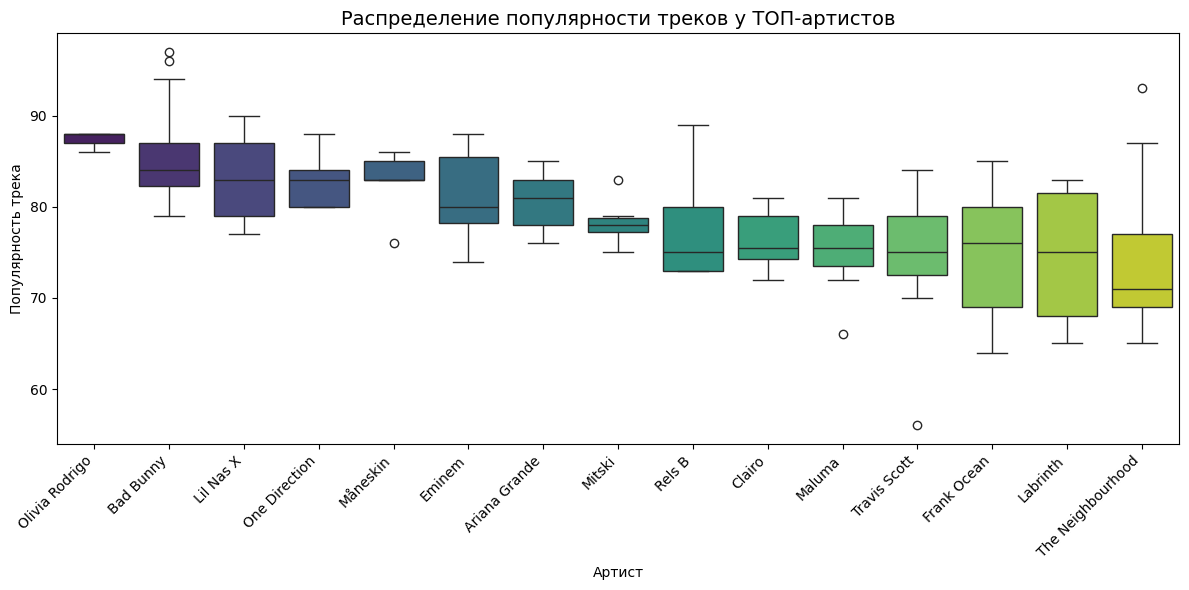

ТОП-5 артистов по средней популярности:
              artists  mean_popularity  track_count
20502  Olivia Rodrigo        87.400000            5
2855        Bad Bunny        85.363636           22
15946       Lil Nas X        83.200000            5
20563   One Direction        83.000000            5
19340        Måneskin        82.600000            5


In [37]:

df['artists'] = df['artists'].str.split(',')
df = df.explode('artists')
df['artists'] = df['artists'].str.strip()

# Считаем статистику по артистам 
artist_stats = (
    df.groupby('artists', as_index=False)
      .agg(
          mean_popularity=('popularity', 'mean'),
          median_popularity=('popularity', 'median'),
          track_count=('track_id', 'count')
      )
)

# Берём артистов с достаточным количеством треков 
artist_stats = artist_stats[artist_stats['track_count'] >= 5]

# Сортируем по средней популярности
top_artists = artist_stats.sort_values('mean_popularity', ascending=False).head(15)


plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_artists,
    x='mean_popularity',
    y='artists',
    hue='track_count',
    dodge=False,
    palette='viridis'
)
plt.title("ТОП-15 артистов по средней популярности треков", fontsize=14)
plt.xlabel("Средняя популярность")
plt.ylabel("Артист")
plt.legend(title="Количество треков", loc='lower right')
plt.tight_layout()
plt.show()

top_names = top_artists['artists'].tolist()
top_tracks = df[df['artists'].isin(top_names)]

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=top_tracks,
    x='artists',
    y='popularity',
    order=top_names,
    palette='viridis'
)
plt.title("Распределение популярности треков у ТОП-артистов", fontsize=14)
plt.xlabel("Артист")
plt.ylabel("Популярность трека")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Текстовый анализ ---
print("ТОП-5 артистов по средней популярности:")
print(top_artists[['artists', 'mean_popularity', 'track_count']].head())


### Выводы: 
* У топовых артистов стабильно высаокая популярность

гипотезу можно считать подтверждённой


## Распределение основных числовых признаков

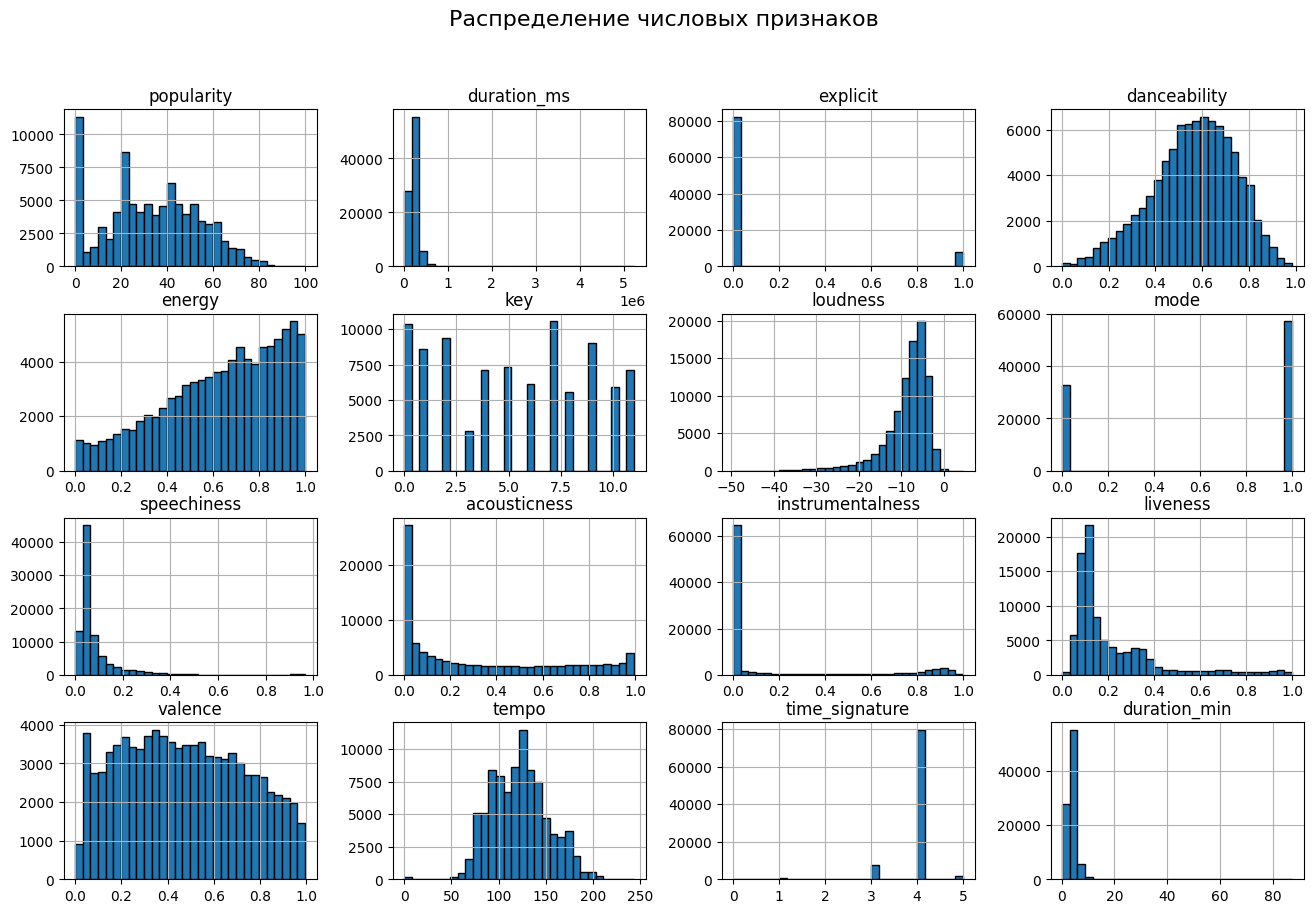

In [38]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols].hist(figsize=(16,10), bins=30, edgecolor='black')
plt.suptitle('Распределение числовых признаков', fontsize=16)
plt.show()

**Вывод:** 
 - Большинство признаков распределено неравномерно — есть перекосы. 
 - В `speechiness`, `acousticness` и `instrumenalness` видны сильные выбросы в районе низких значений
 - Трэков с матом (`explicit`) сильно меньше, чем без мата, однако из средняя популярность выше (график был выше)
 

## Feature eng.

Проделаем следующий прэкол:
| Новая колонка                   | Формула / идея| Интерпретация|
| ------------------------------- | --------------|------------- |
| **`acoustic_energy_diff`**      | `energy - acousticness`                         | Чем выше, тем “более электронный” трек                                 |
| **`mood`**       | `(danceability + valence + energy) / 3`                        |  настроение трека      |
| **`intensity`**           | `(energy + loudness_norm ) / 2` |  “насыщенность звучания” |


In [39]:
df['acoustic_energy_diff'] = df['energy'] - df['acousticness']
df['mood'] = (df['danceability']+df['valence'] + df['energy']) / 3
df['intensity'] = (df['energy'] + df['loudness']) / abs(df['loudness'].max()) / 2

df['loudness_norm'] = (df['loudness'] - df['loudness'].min()) / (df['loudness'].max() - df['loudness'].min())
df['intensity'] = (df['energy'] + df['loudness_norm']) / 2

del df['loudness_norm']
df.head(3)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,instrumentalness,liveness,valence,tempo,time_signature,track_genre,duration_min,acoustic_energy_diff,mood,intensity
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,0,0.676,0.461,1,...,0.000001,0.358,0.715,87.917,4,acoustic,3.844433,0.4288,0.617333,0.626196
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,0,0.420,0.166,1,...,0.000006,0.101,0.267,77.489,4,acoustic,2.493500,-0.7580,0.284333,0.381689
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,0,0.438,0.359,0,...,0.000000,0.117,0.120,76.332,4,acoustic,3.513767,0.1490,0.305667,0.547561


### Feature Importance и простая модель
В качестве простой модели возьмём `RandomForestRegressor`

C:\Users\User\AppData\Local\Temp\ipykernel_12652\990182766.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values[:15], y=importances.index[:15], palette='coolwarm')


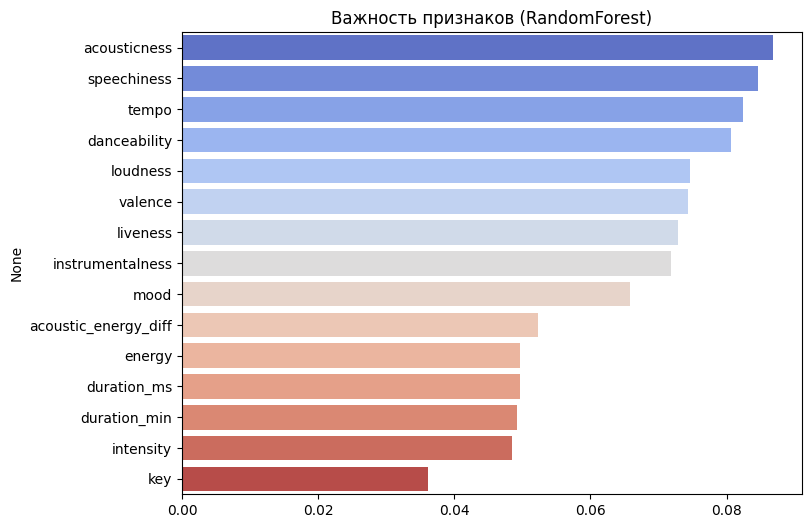

acousticness            0.086744
speechiness             0.084570
tempo                   0.082338
danceability            0.080702
loudness                0.074655
valence                 0.074346
liveness                0.072837
instrumentalness        0.071896
mood                    0.065868
acoustic_energy_diff    0.052336
dtype: float64

In [40]:
# Отберем числовые признаки
X = df.select_dtypes(include=['float64', 'int64']).drop(columns=['popularity'])
y = df['popularity']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# y_scaled = scaler.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


model = RandomForestRegressor(n_estimators=52, random_state=42)
model.fit(X_train, y_train)

importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=importances.values[:15], y=importances.index[:15], palette='coolwarm')
plt.title('Важность признаков (RandomForest)')
plt.show()
importances.head(10)

### Выводы из FI
Важность всех числовых фичей не превосходит 0.09 -> <br>
вариант а) Ни одна фича не важна и таргет случаен <br>
вариант б) зависимость таргета от фичей очень нелинейна и неочевидна

## МЕТРИКИ


### Линейная модель

In [41]:

X = df.select_dtypes(include=['float64', 'int64']).drop(columns=['popularity'])
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_lin = linear_model.predict(X_test)

print("=== Linear Regression ===")
print(f"R²: {r2_score(y_test, y_pred_lin):.4f}")
print(f"Mean abs error: {mean_absolute_error(y_test, y_pred_lin):.4f}")
print(f"Root mean square error: {root_mean_squared_error(y_test, y_pred_lin):.4f}\n")


=== Linear Regression ===
R²: 0.0309
Mean abs error: 16.5479
Root mean square error: 20.1019



### Дерево решений

In [42]:
tree_model = DecisionTreeRegressor(max_depth=8, random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

print("=== Decision Tree ===")
print(f"R²: {r2_score(y_test, y_pred_tree):.4f}")
print(f"Mean abs error: {mean_absolute_error(y_test, y_pred_tree):.4f}")
print(f"Mean square error (RMSE): {root_mean_squared_error(y_test, y_pred_tree):.4f}\n")


=== Decision Tree ===
R²: 0.0813
Mean abs error: 15.7927
Mean square error (RMSE): 19.5722



### Градиентный бустинг

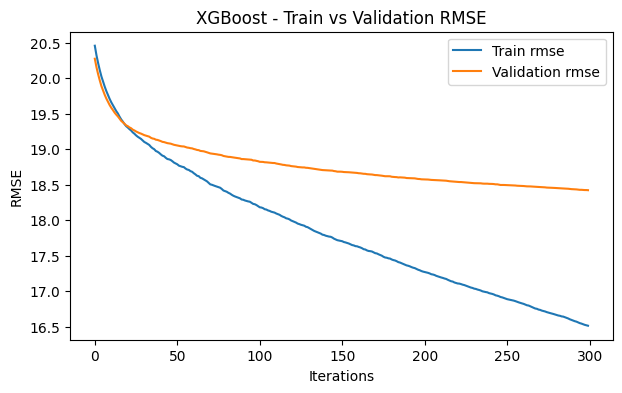

In [43]:

xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.1, random_state=42, verbosity=0)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)
results = xgb_model.evals_result()

plt.figure(figsize=(7,4))
plt.plot(results['validation_0']['rmse'], label='Train rmse')
plt.plot(results['validation_1']['rmse'], label='Validation rmse')
plt.title('XGBoost - Train vs Validation RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend()
plt.show()



### Нейронная сеть

In [46]:

Sequential_model = Sequential()
Sequential_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
Sequential_model.add(Dense(32, activation='relu'))
Sequential_model.add(Dense(1))

Sequential_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = Sequential_model.fit(X_train, y_train, epochs=20, batch_size=32,
                               validation_split=0.2)

y_pred_nn = Sequential_model.predict(X_test).flatten()

print("=== Neural Network ===")
print(f"R²: {r2_score(y_test, y_pred_nn):.4f}")
print(f"Mean abs error: {mean_absolute_error(y_test, y_pred_nn):.4f}")
print(f"Root mean square error (RMSE): {root_mean_squared_error(y_test, y_pred_nn):.4f}\n")

Epoch 1/20


c:\apps\Python13\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1800/1800 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 470.4278 - mae: 17.5349 - val_loss: 410.7516 - val_mae: 16.5050
Epoch 2/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 399.5817 - mae: 16.2495 - val_loss: 402.2060 - val_mae: 16.2605
Epoch 3/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 393.0696 - mae: 16.0825 - val_loss: 395.9151 - val_mae: 16.1069
Epoch 4/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 389.2771 - mae: 15.9848 - val_loss: 393.8033 - val_mae: 16.0504
Epoch 5/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 386.9319 - mae: 15.9248 - val_loss: 393.5799 - val_mae: 15.9837
Epoch 6/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 385.6224 - mae: 15.8744 - val_loss: 393.5060 - val_mae: 15.9411
Epoch 7/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 384.4458 - mae: 15.8489 - val_loss: 389.0710 - val_mae: 15.8911
Epoch 8/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 383.2697 - mae: 15.8124 - val_loss: 391.2479 - val_mae: 15.9608
Epo

## Кросс-валидация

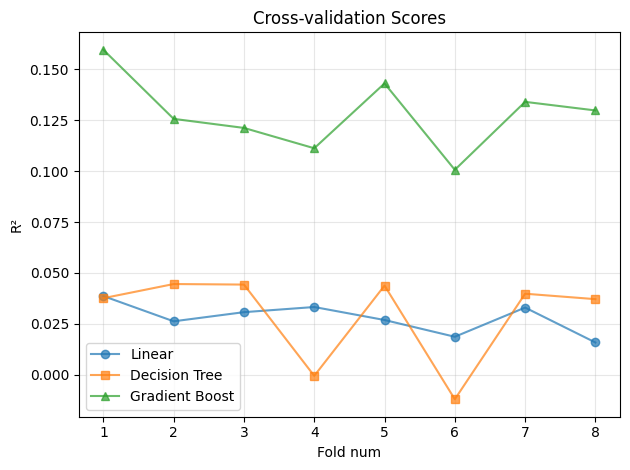

LinearRegression: R² mean=0.0337 ± 0.0029
DecisionTree: R² mean=0.0830 ± 0.0041
XGBoost: R² mean=0.1750 ± 0.0033

=== Кросс-валидация моделей ===


,Model,R2_mean,R2_std
2,XGBoost,0.174965,0.003334
1,DecisionTree,0.082988,0.004106
0,LinearRegression,0.033719,0.002855


In [45]:

models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(max_depth=8, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42, verbosity=0),
    # "Neural network": Sequential_model
}

kf = KFold(n_splits=8, shuffle=True, random_state=42)
results = []

linear_score = cross_val_score(models['LinearRegression'], X_test, y_test, cv=kf,  scoring='r2')
tree_score = cross_val_score(models["DecisionTree"], X_test, y_test, cv=kf,  scoring='r2')
grad_boost_score = cross_val_score(models["XGBoost"], X_test, y_test, cv=kf,  scoring='r2')

plt.plot(np.arange(1, 9), linear_score, 'o-', label=f'Linear', alpha=0.7)
plt.plot(np.arange(1, 9), tree_score, 's-', label=f'Decision Tree', alpha=0.7)
plt.plot(np.arange(1, 9), grad_boost_score, '^-', label=f'Gradient Boost', alpha=0.7)

plt.xlabel('Fold num')
plt.ylabel('R²')
plt.title('Cross-validation Scores')
plt.legend()
plt.grid(alpha=0.3)
# plt.xticks(x_folds)
plt.tight_layout()
plt.show()

for name, model in models.items():
    cv_r2 = cross_val_score(model, X, y, cv=kf, scoring='r2')
    print(f"{name}: R² mean={cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
    results.append([name, cv_r2.mean(), cv_r2.std()])

results_df = pd.DataFrame(results, columns=['Model', 'R2_mean', 'R2_std']).sort_values(by='R2_mean', ascending=False)
print("\n=== Кросс-валидация моделей ===")
display(results_df)



### **Выводы**
Полученные результаты 
| Модель                | Средний R² (8 фолдов) | Интерпретация                                                           |
| :-------------------- | :--------------------: | :---------------------------------------------------------------------- |
| **XGBoost**           |        **0.174**       | Лучшая среди рассмотренных моделей. Объясняет ~17% изменчивости таргета |
|**Neural network**     |          0.096         | Среднее качество модели|
| **Decision Tree**     |          0.082         | Среднее качество, модель улавливает слабые зависимости                  |
| **Linear Regression** |          0.034         | Почти не объясняет дисперсию, зависимость слабая                        |

**Интерпретация:**
Значения R² находятся в диапазоне от **0.03 до 0.17**, что говорит о том,
что модели лишь частично объясняют вариацию целевой переменной `popularity`.
Это ожидаемо, так как популярность трека зависит не только от его музыкальных характеристик,
но и от множества внешних факторов — маркетинга, известности исполнителя, даты релиза, трендов и т.д.

**Основные наблюдения:**

* Модель **XGBoost** показала наилучший результат, что подтверждает её способность улавливать нелинейные зависимости.
* **Нейронная сеть** (Sequential) показала умеренное качество предсказаний — лучше линейной модели и дерева решений, но уступает XGBoost
* **Дерево решений** оказалось менее устойчивым и склонным к переобучению.
* **Линейная регрессия** не справилась с задачей из-за слабой линейной зависимости признаков с таргетом.